In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy, torch
from torch import nn,optim
plt.rcParams.update({'font.size': 14})
figure_folder = 'WH-figures/'

#follow the intruction in deepSI on github to install our preliminary toolbox
import deepSI

## Load Wiener-Hammerstein (WH) data

see: https://sites.google.com/view/nonlinear-benchmark/benchmarks/wiener-hammerstein?authuser=0

In [14]:
train, test = deepSI.datasets.WienerHammerBenchMark(split_data=True) #will download the dataset into C:/Users/user/AppData/Local/deepSI/data_sets
print('train =',train, train.y.shape, train.u.shape) #training and validation is combined into one training set
print('test =',test, test.y.shape, test.u.shape)

train = System_data of length: 100000 nu=None ny=None normed=False (100000,) (100000,)
test = System_data of length: 78800 nu=None ny=None normed=False (78800,) (78800,)


## Fit/load state-space encoder model

In [15]:
if False: #train model
    sys = deepSI.fit_systems.System_encoder(nx=6,na=50,nb=50) #load the encoder system
    sys.n_hidden_layers = 1
    sys.n_nodes_per_layer = 15
    sys.fit(train, epochs=100_000, batch_size=1024, Loss_kwargs=dict(nf=80), sim_val=train[-20000:]) #can be stopped early with keyboard
    #nf = number of steps in each encoder mutiple schooting section (T in the paper)
    sys.save_system('./WH-data/nx6WH-encoder')
    sim_val = train[-40_000:] #larger validation set
    sys.bestfit = sys.apply_experiment(sim_val).NRMS(sim_val) #reset checkpoint
    #use all the data for final local minima search
    sys.fit(train, epochs=500 ,batch_size=10**10, Loss_kwargs=dict(nf=80), sim_val=sim_val) 
    sys.save_system('./WH-data/nx6WH-encoder-stepped')
else: #load model from file
    sys = deepSI.load_system('./WH-data/nx6WH-encoder-stepped')

## Fit/load BLA model

In [16]:
if False: #train model
    sys_BLA = deepSI.fit_systems.statespace_linear_system(nx=6) 
    sys_BLA.fit(train) #uses N4SID method, SS_f=20 (code used from https://github.com/CPCLAB-UNIPI/SIPPY/blob/master/sippy/OLSims_methods.py)
    sys_BLA.save_system('./WH-data/nx6WH-BLA')
else: #load model from file
    sys_BLA = deepSI.load_system('./WH-data/nx6WH-BLA')

## Calculate test RMS/NRMS simulation

 * NRMS = RMS/$\sigma_y$

In [17]:
test_encoder_sim = sys.apply_experiment(test) #simulation
train_encoder_sim = sys.apply_experiment(train) #simulation

In [18]:
print('Test set result:')
print(f'   NRMS test  encoder {test_encoder_sim.NRMS(test):.5%} ')
print(f'    RMS test  encoder {test_encoder_sim.RMS(test)*1000:.5} mV')
print('\nTrain set result:')
print(f'   NRMS train encoder {train_encoder_sim.NRMS(train):.5%} ')
print(f'    RMS train encoder {train_encoder_sim.RMS(train)*1000:.5} mV')
print('\nsigma_y =',np.mean(test.y**2)**0.5)

Test set result:
   NRMS test  encoder 0.09870% 
    RMS test  encoder 0.24068 mV

Train set result:
   NRMS train encoder 0.09789% 
    RMS train encoder 0.23944 mV

sigma_y = 0.24715164906136317


## Error analysis
### Time domain

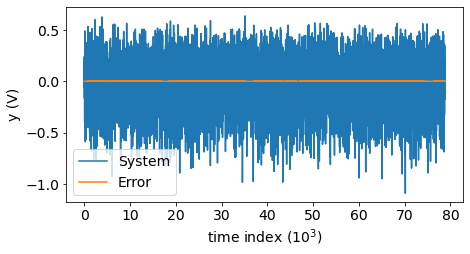

In [19]:
plt.figure(figsize=(9*0.75,5*0.75))
time = np.arange(len(test_encoder_sim))/1000
plt.plot(time,test.y)
plt.plot(time,test.y-test_encoder_sim.y)
plt.legend(['System','Error'])
plt.xlabel('time index ($10^3$)')
plt.ylabel('y (V)')
plt.tight_layout()
plt.savefig(figure_folder+'error-time.pdf')
plt.savefig(figure_folder+'error-time.png',dpi=200)
plt.show()

### Frequency/Fourier domain

#### Load other models

In [8]:
test_BLA_sim = sys_BLA.apply_experiment(test) #simulation
print('BLA test simulation result:')
print(f'  NRMS {test_BLA_sim.NRMS(test):.5%}') #don't know why it is lower than BLA from Lauwers et al 2009. 
print(f'   RMS {test_BLA_sim.RMS(test)*1000:.6}') #don't know why it is lower than BLA from Lauwers et al 2009. 

y_test_NLLFR_res = scipy.io.loadmat('./WH-data/yval-matlab-NL-LFR.mat')['yValSSNNdiff'][:,0] #residual of the NLLFR model
print('\nNLLFR simulation test result:')
print(f'  NRMS {np.mean(y_test_NLLFR_res**2)**0.5/np.std(test.y):.5%}') 
print(f'   RMS {np.mean(y_test_NLLFR_res**2)**0.5*1000:.5}') 

BLA test simulation result:
  NRMS 18.20754%
   RMS 44.4004

NLLFR simulation test result:
  NRMS 0.12059%
   RMS 0.29408


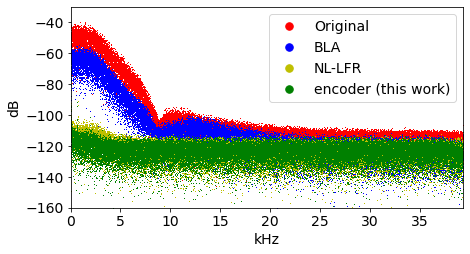

In [9]:
from scipy import fftpack


#two utility function
db = lambda a: 20*np.log10(np.abs(fftpack.fft(a)/len(a))) #convert ot db
Hz = lambda x: np.arange(len(x))/1000 #rescale to kHz
n_skip = 150 #skip transient


#
plt.figure(figsize=(9*0.75,5*0.75))
#original:
ydb = db(test.y[n_skip:]) 
plt.plot(Hz(ydb),ydb,'r,')
#BLA:
ydb = db(test.y[n_skip:]-test_BLA_sim.y[n_skip:]) 
plt.plot(Hz(ydb),ydb,'b,')
#NL-LFR:
ydb = db(y_test_NLLFR_res)
plt.plot(Hz(ydb),ydb,'y,')
#ss-encoder:
ydb = db(test.y[n_skip:]-test_encoder_sim.y[n_skip:])
plt.plot(Hz(ydb),ydb,'g,')

#manual creation of legend (markers dont with with , as marker)
import matplotlib.patches as mpatches
import matplotlib.lines as mlines 
red_line = mlines.Line2D([], [], color='r', marker='.',
                          markersize=15, label='Original',linestyle='None')
blue_line = mlines.Line2D([], [], color='b', marker='.',
                          markersize=15, label='BLA',linestyle='None')
yellow_line = mlines.Line2D([], [], color='y', marker='.',
                          markersize=15, label='NL-LFR',linestyle='None')
green_line = mlines.Line2D([], [], color='g', marker='.',
                          markersize=15, label='encoder (this work)',linestyle='None')
plt.legend(handles=[red_line,blue_line,yellow_line,green_line],loc='upper right')

plt.xlim(0,(len(test)//2-n_skip//2)/1000)
plt.ylabel('dB')
plt.xlabel('kHz')
plt.ylim(-160,-30)
plt.tight_layout()
plt.savefig(figure_folder+'fft.png',dpi=115)
plt.show()

## Training curve figure

### Get other modes of operations 

In [10]:
if False: #train model
    sys_no_encode = deepSI.fit_systems.System_encoder(nx=6,na=1,nb=1) #encoder is used ones to initialize one state, same as parametric start
    sys_no_encode.n_hidden_layers = 1
    sys_no_encode.n_nodes_per_layer = 15
    sys_no_encode.fit(train,epochs=15184,batch_size=1,Loss_kwargs=dict(nf=len(train)-sys.na),sim_val=train[-20000:])
    sys_no_encode.save_system('./WH-data/nx6WH-non-encoder')
else: #load model from file
    sys_no_encode = deepSI.load_system('./WH-data/nx6WH-non-encoder')
    
if False: #train model
    sys_no_batch = deepSI.fit_systems.System_encoder(nx=6,na=50,nb=50) #encoder is used ones to initialize one state, same as parametric start
    sys_no_batch.n_hidden_layers = 1
    sys_no_batch.n_nodes_per_layer = 15
    sys_no_batch.fit(train,epochs=10000,batch_size=99901,Loss_kwargs=dict(nf=80),sim_val=train[-4000:]) #small validation otherwise computation speed is lowered by a lot
    sys_no_batch.save_system('./WH-data/nx6WH-no-batch')
else: #load model from file
    sys_no_batch = deepSI.load_system('./WH-data/nx6WH-no-batch')

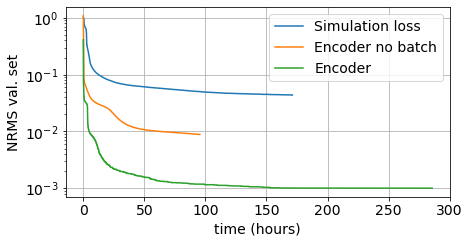

In [13]:
def min_val_array(lis):
    '''Minimum value in to the left'''
    minval = [lis[0]]
    for a in lis[1:]:
        if minval[-1]>a:
            minval.append(a)
        else:
            minval.append(minval[-1])
    return np.array(minval)

plt.figure(figsize=(9*0.75,6*0.6))
label = 'time-compare-2'
plt.grid()

hours = np.array(sys_no_encode.time)/60/60
plt.plot(hours,min_val_array(sys_no_encode.Loss_val),label='Simulation loss')

hours = np.array(sys_no_batch.time)/60/60
plt.plot(hours,min_val_array(sys_no_batch.Loss_val),label='Encoder no batch')

hours = np.array(sys.time[:len(sys.time)//2])/60/60
plt.plot(hours,min_val_array(sys.Loss_val[1:len(sys.time)//2+1]),label='Encoder') #[...+1] is a minor deepSI version mess up correction remove if you retrain the model


plt.xlabel('time (hours)')
plt.legend(loc='upper right')
plt.semilogy()
plt.ylabel('NRMS val. set')
plt.tight_layout()
plt.savefig(figure_folder+f'training-{label}.pdf',dpi=200)
plt.savefig(figure_folder+f'training-{label}.png',dpi=200)
plt.show()

## n-step error

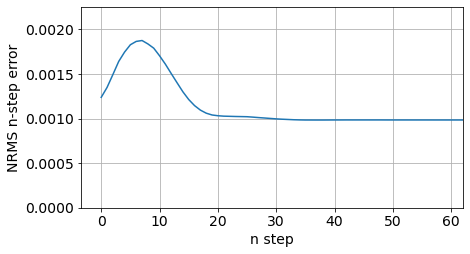

In [12]:
n_step_error = sys.n_step_error(test,nf=70)
plt.figure(figsize=(9*0.75,5*0.75))
plt.plot(n_step_error)
plt.xlabel('n step')
plt.ylabel('NRMS n-step error')
plt.ylim(0,0.00225)
plt.xlim(None,62)
plt.tight_layout()
plt.grid()
plt.savefig(figure_folder+'n-step.pdf')
plt.savefig(figure_folder+'n-step.png',dpi=200)
plt.show()